In [3]:
import pandas as pd
import numpy as np

import sys; sys.path.insert(0, '/Users/AlexH')

from utils.plot import *
from utils.data import *

%matplotlib inline

In [4]:
def get_int_col(x):
    try:
        return int(x[0])
    except:
        return x[1]

def convert_to_int(x):
    try:
        return int(x)
    except:
        return 0

In [5]:
df = pd.read_csv('titanic_train.csv')

df['title'] = df['Name'].str.split(', ', expand=True)[1].str.split('. ', expand=True)[0]

a = df['Ticket'].str.split(' ', expand=True).apply(get_int_col, axis=1)
df['ticket_num'] = a.fillna(0).apply(convert_to_int)

a = df['Cabin'].fillna('missing').str.split(' ', expand=True)[0]
df['cabin_letter'] = a.apply(lambda x: x[0]).replace('m', 'missing')

In [6]:
df1 = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], 1)
df1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,title,ticket_num,cabin_letter
0,0,3,male,22.0,1,0,7.2500,S,Mr,21171,missing
1,1,1,female,38.0,1,0,71.2833,C,Mrs,17599,C
2,1,3,female,26.0,0,0,7.9250,S,Miss,3101282,missing
3,1,1,female,35.0,1,0,53.1000,S,Mrs,113803,C
4,0,3,male,35.0,0,0,8.0500,S,Mr,373450,missing


In [196]:
df2 = pd.get_dummies(df1).fillna(0)

X = df1[df1.columns.difference(['Survived'])]
y = df1['Survived']

In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [215]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer
from sklearn.feature_extraction.text import CountVectorizer

mapper = DataFrameMapper([
            (['Age'], [Imputer(), StandardScaler()]),
            ('title', CountVectorizer()),
            ('Pclass', None),
            ('Sex',  CountVectorizer()),
            ('Fare', None)
        ]
    , df_out=True)

a = mapper.fit_transform(xtrain, ytrain)

# bad_cols = np.setdiff1d(a.columns, xtrain.columns)
# rest_cols = np.setdiff1d(xtrain.columns, a.columns)
# a.rename(columns=dict(zip(bad_cols, rest_cols)))

In [216]:
cross_val_score(make_pipeline(mapper, LogisticRegression()), xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.84570989841719812

In [195]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.66844223954642112

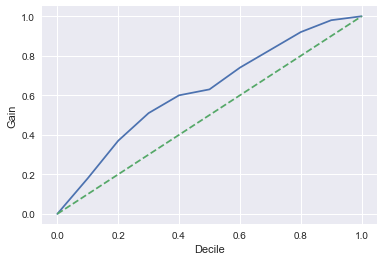

In [74]:
model.fit(xtrain, ytrain)
plot_gains_curve(model, xtest, ytest)

In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.83966501299314911

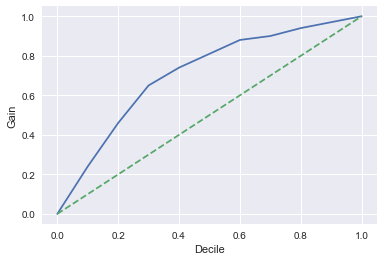

In [54]:
model.fit(xtrain, ytrain)
plot_gains_curve(model, xtest, ytest)

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.86886746987951802

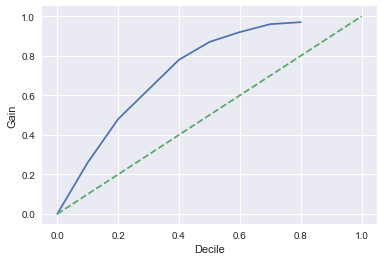

In [80]:
model.fit(xtrain, ytrain)
plot_gains_curve(model, xtest, ytest)

In [84]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=10)

cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.63604346798960554

In [83]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.65290810300023616

In [82]:
from sklearn.svm import SVC

model = SVC()

cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.60799527521852115

In [89]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

paramgrid = {"kernel": ["rbf"],
             "C"     : np.logspace(-9, 9, num=25, base=10),
             "gamma" : np.logspace(-9, 9, num=25, base=10)}


evo = EvolutionaryAlgorithmSearchCV(estimator=SVC(),
                                   params=paramgrid,
                                   scoring="roc_auc",
                                   cv=5,
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
evo.fit(xtrain, ytrain)

Types [1, 2, 2] and maxint [0, 24, 24] detected
--- Evolve in 625 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	50    	0.570081	0.509551	0.673497	0.0597408
1  	35    	0.634129	0.510712	0.683374	0.0404251
2  	21    	0.660608	0.532516	0.683374	0.0237042
3  	23    	0.668238	0.559   	0.683374	0.0235565
4  	31    	0.678457	0.673497	0.694323	0.00538066
5  	31    	0.679262	0.603713	0.71806 	0.0164355 
Best individual is: {'kernel': 'rbf', 'C': 1000000000.0, 'gamma': 1.0000000000000001e-09}
with fitness: 0.718059883069


In [ ]:
from sklearn.grid_search import RandomizedSearchCV

rs = RandomizedSearchCV(model, params=param_grid, cv=5, scoring="roc_auc")
rs.fit(xtrain, ytrain)


In [ ]:
print rs.best_params_
print rs.best_score_

In [88]:
from xgboost import XGBClassifier

model = XGBClassifier()

cross_val_score(model, xtrain, ytrain, scoring='roc_auc', cv=cv).mean()

0.86085235057878573